PWC-Net-small model evaluation (on MPI-Sintel 'final')
============================================

In this notebook we:
- Evaluate the PWC-Net-small model trained on a mix of the `FlyingChairs` and `FlyingThings3DHalfRes` datasets using the Cyclic<sub>short</sub> schedule
- Run the evaluation on the **'final'** version of the dataset, yielding an average EPE of 5.41
- Perform basic error analysis

Below, look for `TODO` references and customize this notebook based on your own machine setup.

## Reference

[2018a]<a name="2018a"></a> Sun et al. 2018. PWC-Net: CNNs for Optical Flow Using Pyramid, Warping, and Cost Volume. [[arXiv]](https://arxiv.org/abs/1709.02371) [[web]](http://research.nvidia.com/publication/2018-02_PWC-Net%3A-CNNs-for) [[PyTorch (Official)]](https://github.com/NVlabs/PWC-Net/tree/master/PyTorch) [[Caffe (Official)]](https://github.com/NVlabs/PWC-Net/tree/master/Caffe)

In [1]:
"""
pwcnet_eval.ipynb

PWC-Net model evaluation.

Written by Phil Ferriere

Licensed under the MIT License (see LICENSE for details)
"""
from __future__ import absolute_import, division, print_function
import sys
from copy import deepcopy
import pandas as pd
import seaborn as sns

from dataset_base import _DEFAULT_DS_VAL_OPTIONS
from dataset_mpisintel import MPISintelDataset
from model_pwcnet import ModelPWCNet, _DEFAULT_PWCNET_VAL_OPTIONS
from visualize import display_img_pairs_w_flows

%matplotlib inline

## TODO: Set this first!

In [2]:
# TODO: You MUST set dataset_root to the correct path on your machine!
if sys.platform.startswith("win"):
    _DATASET_ROOT = 'E:/datasets/'
else:
    _DATASET_ROOT = '/media/EDrive/datasets/'
_MPISINTEL_ROOT = _DATASET_ROOT + 'MPI-Sintel'
    
# TODO: Set device on which to perform the evaluation
gpu_devices = ['/device:GPU:0'] # We're doing the evaluation on a single GPU
controller = '/device:GPU:0'

# More options...
mode = 'val_notrain'            # We're doing evaluation using the entire dataset for evaluation
num_samples = 10                # Number of samples for error analysis
ckpt_path = './models/pwcnet-sm-6-2-cyclic-chairsthingsmix/pwcnet.ckpt-49000' # Model to eval

## Load the dataset

In [3]:
# Load the dataset in evaluation mode, starting with the default evaluation options
ds_opts = deepcopy(_DEFAULT_DS_VAL_OPTIONS)
ds_opts['type'] = 'final'
ds = MPISintelDataset(mode=mode, ds_root=_MPISINTEL_ROOT, options=ds_opts)

In [4]:
# Display dataset configuration
ds.print_config()


Dataset Configuration:
  verbose              False
  in_memory            False
  crop_preproc         None
  scale_preproc        None
  input_channels       3
  type                 final
  random_seed          1969
  val_split            0.03
  aug_type             None
  mode                 val_notrain


## Configure the evaluation process

In [5]:
# Configure the model for evaluation, starting with the default evaluation options
nn_opts = deepcopy(_DEFAULT_PWCNET_VAL_OPTIONS)
nn_opts['verbose'] = True
nn_opts['ckpt_path'] = ckpt_path
nn_opts['batch_size'] = 1               # Setting this to 1 leads to more accurate evaluations of the processing time 
nn_opts['use_tf_data'] = False          # Don't use tf.data reader for this simple task
nn_opts['gpu_devices'] = gpu_devices
nn_opts['controller'] = controller      # Evaluate on CPU or GPU?

# We're evaluating the PWC-Net-small model in quarter-resolution mode
# That is, with a 6 level pyramid, and uspampling of level 2 by 4 in each dimension as the final flow prediction
nn_opts['use_dense_cx'] = False
nn_opts['use_res_cx'] = False
nn_opts['pyr_lvls'] = 6
nn_opts['flow_pred_lvl'] = 2

In [6]:
# Instantiate the model in evaluation mode and display the model configuration
nn = ModelPWCNet(mode=mode, options=nn_opts, dataset=ds)
nn.print_config()

Building model...
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
... model built.
Loading model checkpoint ./models/pwcnet-sm-6-2-cyclic-chairsthingsmix/pwcnet.ckpt-49000 for eval or testing...

INFO:tensorflow:Restoring parameters from ./models/pwcnet-sm-6-2-cyclic-chairsthingsmix/pwcnet.ckpt-49000
... model loaded

Model Configuration:
  verbose                True
  ckpt_path              ./models/pwcnet-sm-6-2-cyclic-chairsthingsmix/pwcnet.ckpt-49000
  x_dtype                <dtype: 'float32'>
  x_shape                [2, None, None, 3]
  y_dtype                <dtype: 'float32'>
  y_shape                [None, None, 2]
  gpu_devices            ['/device:GPU:0']
  controller             /device:GPU:0
  use_tf_data            False
  batch_size             1
  pyr_lvls               6
  flow_pred_lvl          2
  search_range           4
  use_dense_cx           False
  use_res_cx             False
  mode                   val_notrain
  trainable pa

## Evaluate the model

In [7]:
# Evaluate the performance of the model on the dataset
# Save the predictions to disk for error analysis
# Also, get a panda dataframe with info about each sample for further error analysis
avg_metric, avg_duration, df = nn.eval(metric_name='EPE', save_preds=True)

Measuring EPE and saving preds: 100%|###########################| 1041/1041 [05:09<00:00,  3.36it/s]


In [8]:
print(f'Average EPE={avg_metric:.2f}, mean inference time={avg_duration*1000.:.2f}ms')

Average EPE=5.41, mean inference time=59.69ms


## Error analysis

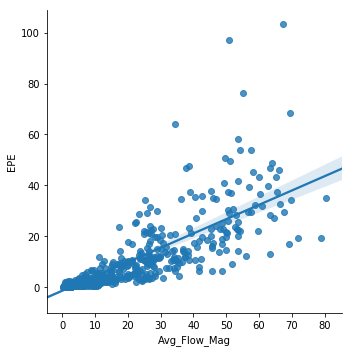

In [9]:
# Is there a correlation between average flow magnitude and EPE?
sns.lmplot(x='Avg_Flow_Mag', y='EPE', data=df, fit_reg=True)

In [10]:
# Which are the 10 worst performers by EPE?
df = df.sort_values(by='EPE')
df_worst = df.tail(num_samples).iloc[::-1]
df_worst

ID         EPE  Duration  Avg_Flow_Mag  \
706   ambush_4/frames_0004_0005  103.493660  0.056846     67.450607   
1003  ambush_4/frames_0005_0006   97.207275  0.055851     50.742363   
584   ambush_2/frames_0015_0016   76.384636  0.055851     55.136871   
619   ambush_4/frames_0003_0004   68.496964  0.056849     69.624336   
201   ambush_2/frames_0014_0015   64.081802  0.055851     34.325573   
729   ambush_5/frames_0048_0049   58.093174  0.054854     53.709454   
933     cave_2/frames_0025_0026   53.855408  0.054853     54.253807   
791   ambush_6/frames_0015_0016   53.743401  0.057844     57.727638   
846     cave_2/frames_0033_0034   50.935272  0.056847     49.736172   
336     cave_2/frames_0023_0024   49.765572  0.054853     51.117649   

      Max_Flow_Mag  
706     175.425064  
1003    132.216675  
584     114.062172  
619     248.640671  
201     118.359818  
729     205.011307  
933     120.331169  
791     206.460571  
846     110.202431  
336     194.486221

In [11]:
mean_avg_flow_mag = df['Avg_Flow_Mag'].mean()
mean_avg_flow_mag

11.980764999541952

In [12]:
# Which are the 10 best performers with an average flow magnitude?
df_best = df[df['Avg_Flow_Mag'] >= mean_avg_flow_mag].sort_values(by='EPE').head(int(num_samples))
df_best

ID       EPE  Duration  Avg_Flow_Mag  Max_Flow_Mag
384  ambush_7/frames_0039_0040  1.492240  0.055850     15.111463     55.126717
551    cave_2/frames_0044_0045  1.853484  0.054854     16.217222     24.238844
443  temple_3/frames_0017_0018  1.936186  0.055851     14.069028     50.230129
177  temple_3/frames_0016_0017  2.081923  0.057844     13.076794     60.851753
5      cave_2/frames_0045_0046  2.107502  0.053856     12.150459     19.369473
199  market_6/frames_0023_0024  2.210310  0.055852     13.584369     32.971123
728    cave_2/frames_0043_0044  2.268200  0.054853     22.532162     37.458000
361    cave_2/frames_0003_0004  2.322868  0.054852     13.994075     37.644890
990  market_6/frames_0022_0023  2.435499  0.054853     14.951739     33.504551
561    cave_2/frames_0004_0005  2.452407  0.055849     14.051126     44.414948

# Visual assessment

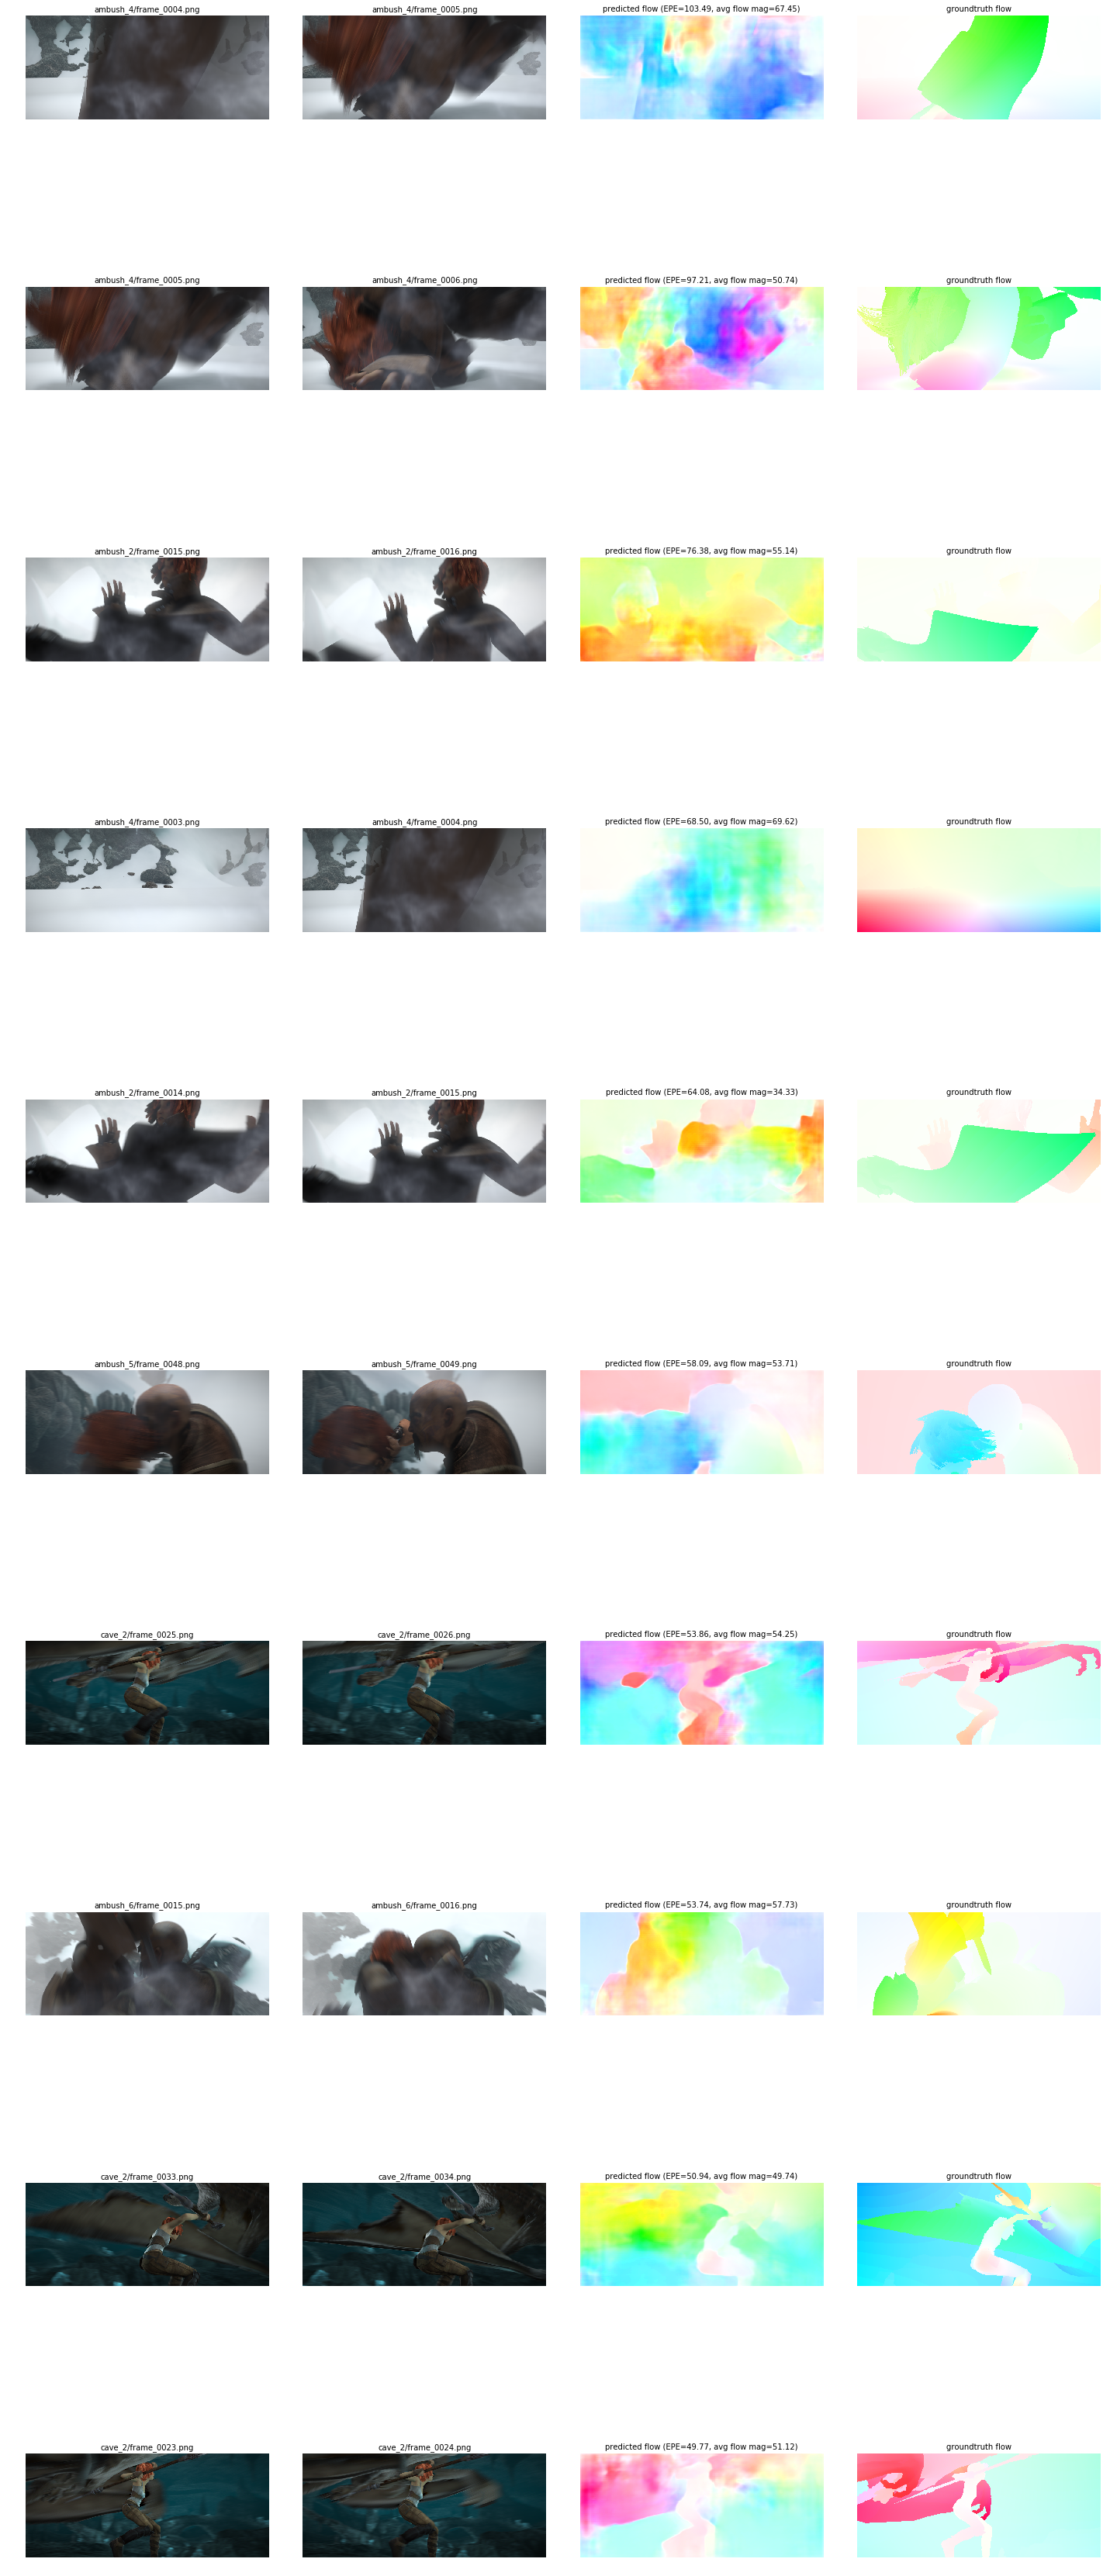

In [13]:
# How do the 10 worst performers look like?
images, labels, pred_labels, ids = ds.get_samples_by_flow_ID(list(df_worst['ID']), split='val_with_preds')
info_text = [f"(EPE={stat[0]:.2f}, avg flow mag={stat[1]:.2f})" for stat in zip(df_worst['EPE'], df_worst['Avg_Flow_Mag'])]
display_img_pairs_w_flows(images, pred_labels, labels, ids, info_text)

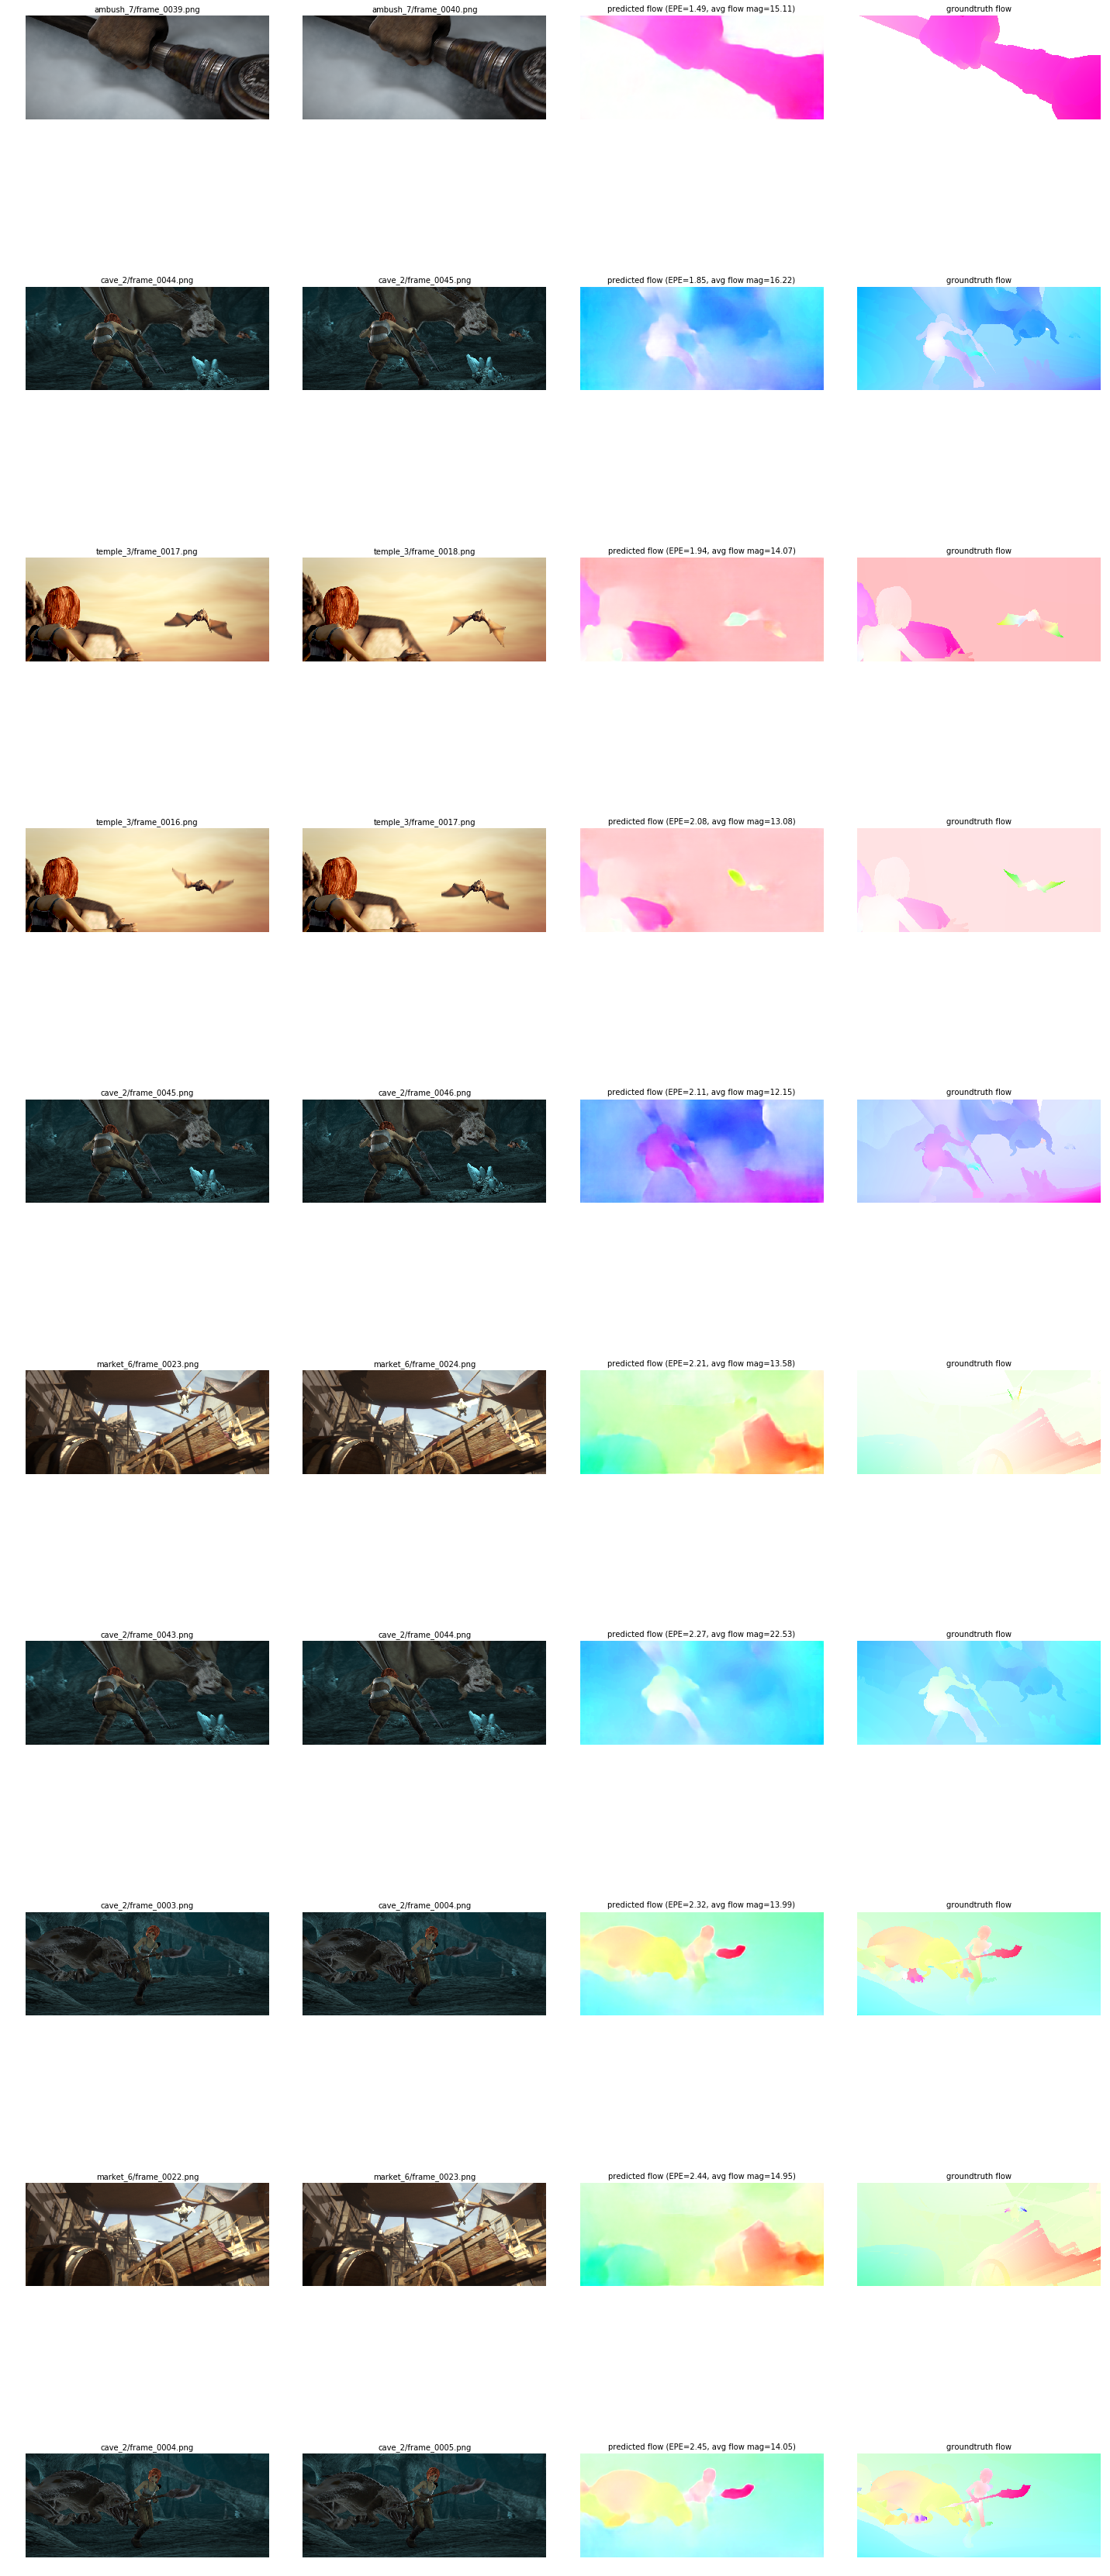

In [14]:
# How do the 10 best performers (with average flow mag) look like?
images, labels, pred_labels, ids = ds.get_samples_by_flow_ID(list(df_best['ID']), split='val_with_preds')
info_text = [f"(EPE={stat[0]:.2f}, avg flow mag={stat[1]:.2f})" for stat in zip(df_best['EPE'], df_best['Avg_Flow_Mag'])]
display_img_pairs_w_flows(images, pred_labels, labels, ids, info_text)